# Smartwatch Health Data Analysis

This project presents a comprehensive data analytics  on smartwatch generated health data. The workflow includes:

- Data cleaning and wrangling,
- Descriptive statistics and visualization,
- Outlier handling,
- Feature engineering (calories burned estimation),
- Linear regression modeling
- Actionable insights for health monitoring.

The aim is to uncover meaningful patterns and predict calorie expenditure using key biometric features.


## Data Loading and Preview

We begin by importing essential libraries and loading the raw dataset. The first few rows are displayed to understand the structure and spot inconsistencies.


In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
df = pd.read_csv('unclean_smartwatch_health_data.csv')

# Display the first few rows of the dataset
print("First ten rows of the dataset:")
print(df.head(10))

# Loop through all columns to inspect data type, unique values, and missing values
for col in df.columns:
    print(f"Column: {col}")
    print("Data Type:", df[col].dtype)
    print("Unique Values Count:", df[col].nunique())
    # Display unique values if the number of unique values is small
    if df[col].nunique() < 10:
        print("Unique Values:", df[col].unique())
    else:
        print("Sample Unique Values:", df[col].unique()[:10])
    print("Missing Values:", df[col].isnull().sum())
    print("-" * 40)


# Overview of the dataset structure and summary statistics
print("Missing values per column:")
print(df.isnull().sum())
print("\nNumber of duplicate records:", df.duplicated().sum())

First ten rows of the dataset:
   User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
0   4174.0         58.939776               98.809650   5450.390578   
1   4174.0         58.939776               98.809650   5450.390578   
2      NaN               NaN               98.532195    727.601610   
3   1860.0        247.803052               97.052954   2826.521994   
4   1860.0        247.803052               97.052954   2826.521994   
5   2294.0         40.000000               96.894213  13797.338044   
6   2130.0         61.950165               98.583797  15679.067648   
7   2095.0         96.285938               94.202910  10205.992256   
8   1860.0        247.803052               97.052954   2826.521994   
9   4772.0         47.272257               95.389760   3208.781177   

  Sleep Duration (hours) Activity Level Stress Level  
0      7.167235622316564  Highly Active            1  
1      7.167235622316564  Highly Active            1  
2      6.538239375570314  Highly_

## Data Cleaning & Preprocessing

Initial inspection revealed:
- Typos in categorical values (e.g., "Actve", "Seddentary"),
- Missing values in key features,
- Negative Value in `Sleep Duration`
- "ERROR" placeholders in numeric columns,
- Duplicates in the dataset.

We cleaned the dataset by:
- Standardizing `Activity Level`,
- Converting erroneous numeric fields,
- Handling missing values based on skewness:
  - **Median imputation** for skewed data,
  - **Mean imputation** for symmetric data,
- Removing duplicate entries.

This ensured a consistent and high-quality dataset for analysis.


In [2]:
# Standardise "Activity Level"
df['Activity Level'] = df['Activity Level'].replace({
    'Actve': 'Active',
    'Seddentary': 'Sedentary',
    'Highly Active': 'Highly_Active'
})

# Drop duplicates
df = df.drop_duplicates()

# Check the number of rows with missing user IDs
missing_user_ids = df['User ID'].isnull().sum()
total_rows = len(df)
print(f"Missing user IDs: {missing_user_ids} out of {total_rows} rows.")

# Drop rows where user_id is missing if they represent a small percentage
if missing_user_ids / total_rows < 0.05:  # for example, if less than 5% are missing
    df = df.dropna(subset=['User ID'])
    print("Dropped rows with missing user IDs.")

# Random imputation based on category distribution
# This method keeps the original distribution of the data intact.
# This is ideal because the 'Activity Level' column has no direct correlation with the other features
# Is best because: avoids bias ( not overrepresenting one category), preserves data integrity(keeps the proportions close to the original)
def random_impute(series, seed=42):
    np.random.seed(seed)  # Set the seed for reproducibility
    probs = series.value_counts(normalize=True)
    missing = series.isna()
    series.loc[missing] = np.random.choice(probs.index, size=missing.sum(), p=probs.values)
    return series

# Apply with seed
df['Activity Level'] = random_impute(df['Activity Level'], seed=42)

# **** Calculate skewness for deciding if impute with mean or median ******

# Define columns of interest
cols = ['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count', 'Sleep Duration (hours)', 'Stress Level']

# Convert all selected columns to numeric
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove rows with negative sleep duration
df = df[df['Sleep Duration (hours)'] >= 0]

# For skewness calculation, drop rows with missing values in these columns
original_data = df[cols].dropna()

# Calculate skewness for each column
skew_values = original_data.skew()

# Print skewness for each column
for col in cols:
    print(f"Skewness of {col}: {skew_values[col]:.2f}")


Missing user IDs: 201 out of 10000 rows.
Dropped rows with missing user IDs.
Skewness of Heart Rate (BPM): 3.74
Skewness of Blood Oxygen Level (%): -0.57
Skewness of Step Count: 2.00
Skewness of Sleep Duration (hours): 0.02
Skewness of Stress Level: 0.03


### Imputation Strategy Justification Based on Skewness

Imputation methods were selected based on the skewness of each variable to ensure accurate central tendency estimation and minimize distortion from outliers:

- **Heart Rate (BPM)**: Skewness = 3.74 → *Median imputation* (highly right-skewed)
- **Blood Oxygen Level (%)**: Skewness = -0.57 → *Median imputation* (moderately left-skewed)
- **Step Count**: Skewness = 2.00 → *Median imputation* (right-skewed)
- **Sleep Duration (hours)**: Skewness = 0.02 → *Mean imputation* (nearly symmetric)
- **Stress Level**: Skewness = -0.03 → *Mean imputation* (nearly symmetric)


In [3]:
# Columns to impute using mean (for symmetric distributions)
mean_cols = ['Sleep Duration (hours)', 'Stress Level']

# Columns to impute using median (for skewed distributions)
median_cols = ['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count']

# Loop for filling NaN using mean imputation
for col in mean_cols:
    df[col] = df[col].fillna(df[col].mean())
    print(f"Filled NaN in '{col}' using mean: {df[col].mean():.2f}")

# Loop for filling NaN using median imputation
for col in median_cols:
    df[col] = df[col].fillna(df[col].median())
    print(f"Filled NaN in '{col}' using median: {df[col].median():.2f}")


Filled NaN in 'Sleep Duration (hours)' using mean: 6.50
Filled NaN in 'Stress Level' using mean: 5.45
Filled NaN in 'Heart Rate (BPM)' using median: 75.26
Filled NaN in 'Blood Oxygen Level (%)' using median: 98.00
Filled NaN in 'Step Count' using median: 4980.02


In [4]:
# Reduce the decimal value to 2 for columns with data type floats
for column in df.columns:
    if df[column].dtype == 'float64':
        df[column] = df[column].round(2)

# Check for missing values in each column
print("Missing values per column:")
print(df.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Display DataFrame information (data types, non-null counts)
print("\nDataFrame info:")
df.info()

# View summary statistics to check for anomalies or outliers
print("\nSummary Statistics:")
print(df.describe().round(2))

# Optionally, inspect a few rows to ensure data looks as expected
print("\nFirst 5 rows of the cleaned data:")
print(df.head())


Missing values per column:
User ID                   0
Heart Rate (BPM)          0
Blood Oxygen Level (%)    0
Step Count                0
Sleep Duration (hours)    0
Activity Level            0
Stress Level              0
dtype: int64

Number of duplicate rows: 0

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 9413 entries, 0 to 10004
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 9413 non-null   float64
 1   Heart Rate (BPM)        9413 non-null   float64
 2   Blood Oxygen Level (%)  9413 non-null   float64
 3   Step Count              9413 non-null   float64
 4   Sleep Duration (hours)  9413 non-null   float64
 5   Activity Level          9413 non-null   object 
 6   Stress Level            9413 non-null   float64
dtypes: float64(6), object(1)
memory usage: 588.3+ KB

Summary Statistics:
       User ID  Heart Rate (BPM)  Blood Oxygen Level (%)  Step C

## Descriptive Statistics & Visualisation

We examined the distribution of major health metrics using histograms, scatter plots, and boxplots.

- **Histograms**: Heart Rate, Step Count, and Stress Level show right-skewed patterns.
- **Scatter Plots**: Explored relationships between steps and heart rate.
- **Boxplots**: Illustrated how stress and heart rate vary across different activity levels.

These visuals help reveal trends and potential outliers.


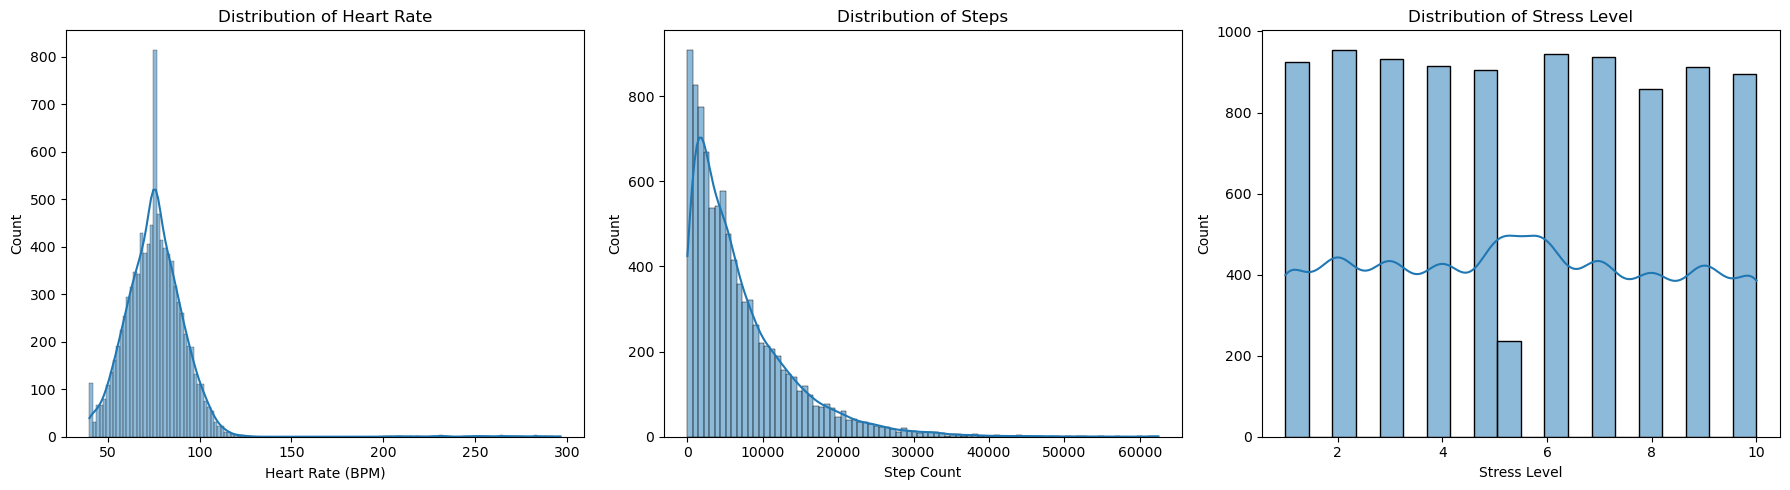

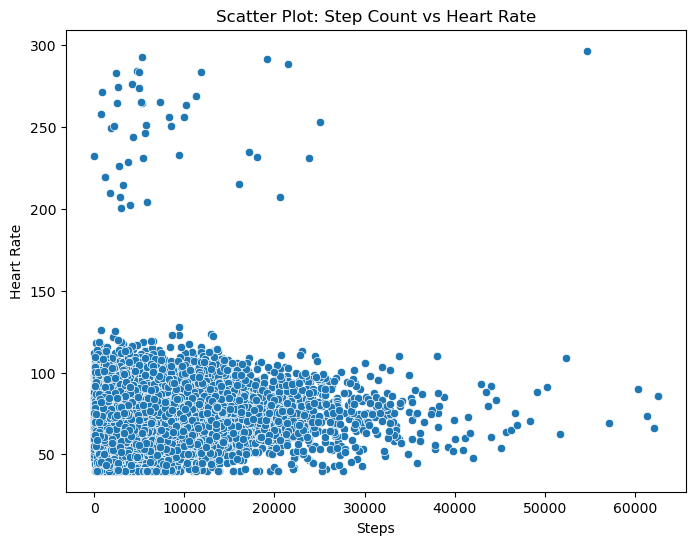

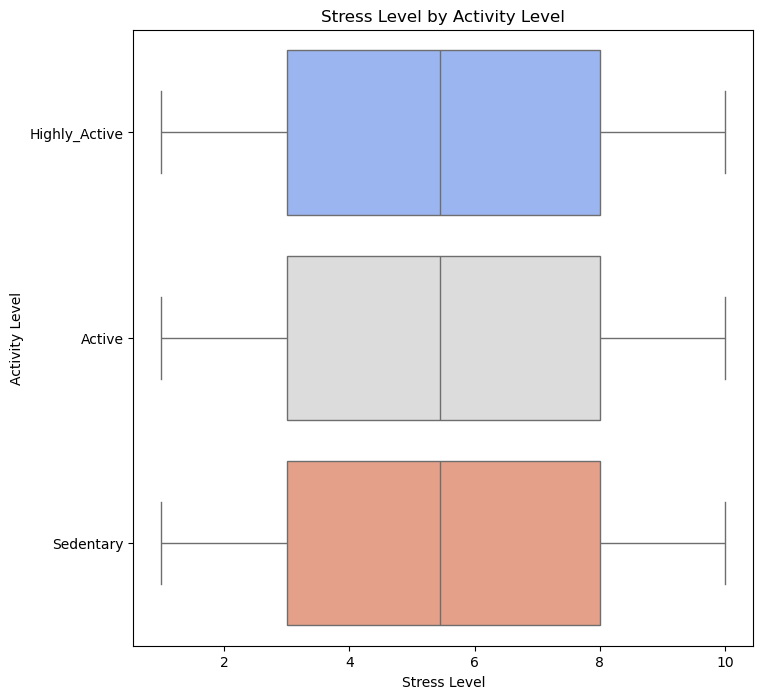

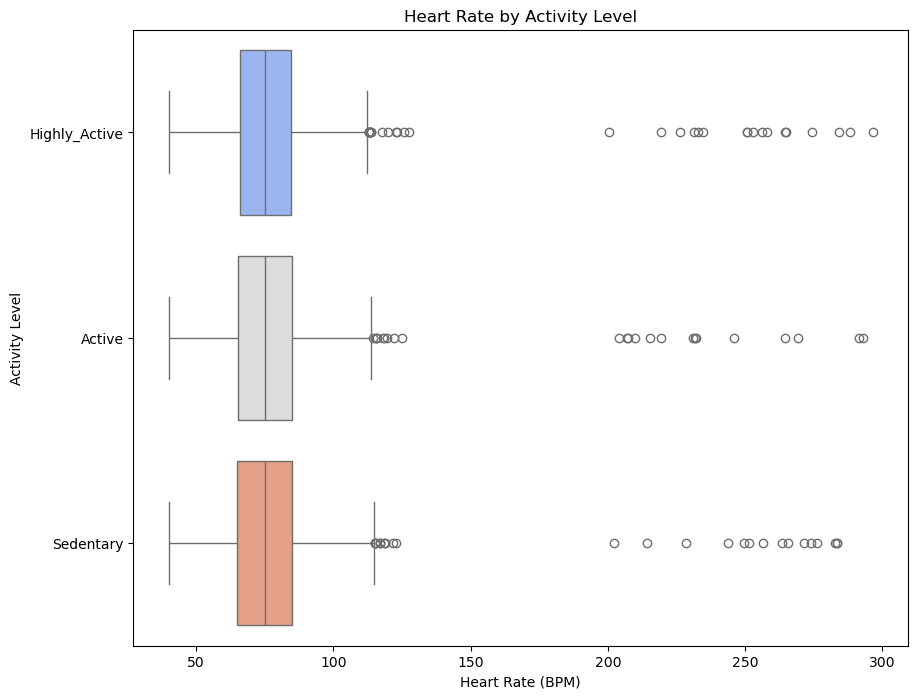

In [5]:
# Plot histograms for key variables
fig, axs = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(df['Heart Rate (BPM)'], kde=True, ax=axs[0])
axs[0].set_title('Distribution of Heart Rate')
sns.histplot(df['Step Count'], kde=True, ax=axs[1])
axs[1].set_title('Distribution of Steps')
sns.histplot(df['Stress Level'], kde=True, ax=axs[2])
axs[2].set_title('Distribution of Stress Level')
plt.tight_layout()
plt.show()

# Create a scatter plot to explore the relationship between steps and heart rate
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Step Count', y='Heart Rate (BPM)', data=df)
plt.title('Scatter Plot: Step Count vs Heart Rate')
plt.xlabel('Steps')
plt.ylabel('Heart Rate')
plt.show()

plt.figure(figsize=(8,8))

sns.boxplot(
    data = df,
    x = 'Stress Level',
    y = 'Activity Level',
    palette = 'coolwarm',
    hue = 'Activity Level'
)

plt.legend([], [], frameon=False)
plt.title('Stress Level by Activity Level')
plt.xticks(size = 10)
plt.xlabel('Stress Level')
plt.ylabel('Activity Level')

plt.show()

plt.figure(figsize=(10,8))

sns.boxplot(
    data = df,
    x = 'Heart Rate (BPM)',
    y = 'Activity Level',
    palette = 'coolwarm',
    hue = 'Activity Level'
)

plt.legend([],[], frameon = False)
plt.title('Heart Rate by Activity Level')
plt.xticks(size = 10)
plt.xlabel('Heart Rate (BPM)')
plt.ylabel('Activity Level')

plt.show()


## Outlier Removal

Outliers were identified and removed using the Interquartile Range (IQR) method on the following columns:

- Heart Rate (BPM)
- Blood Oxygen Level (%)
- Step Count
- Sleep Duration (hours)
- Stress Level

This step is crucial to improve the robustness of our regression model.


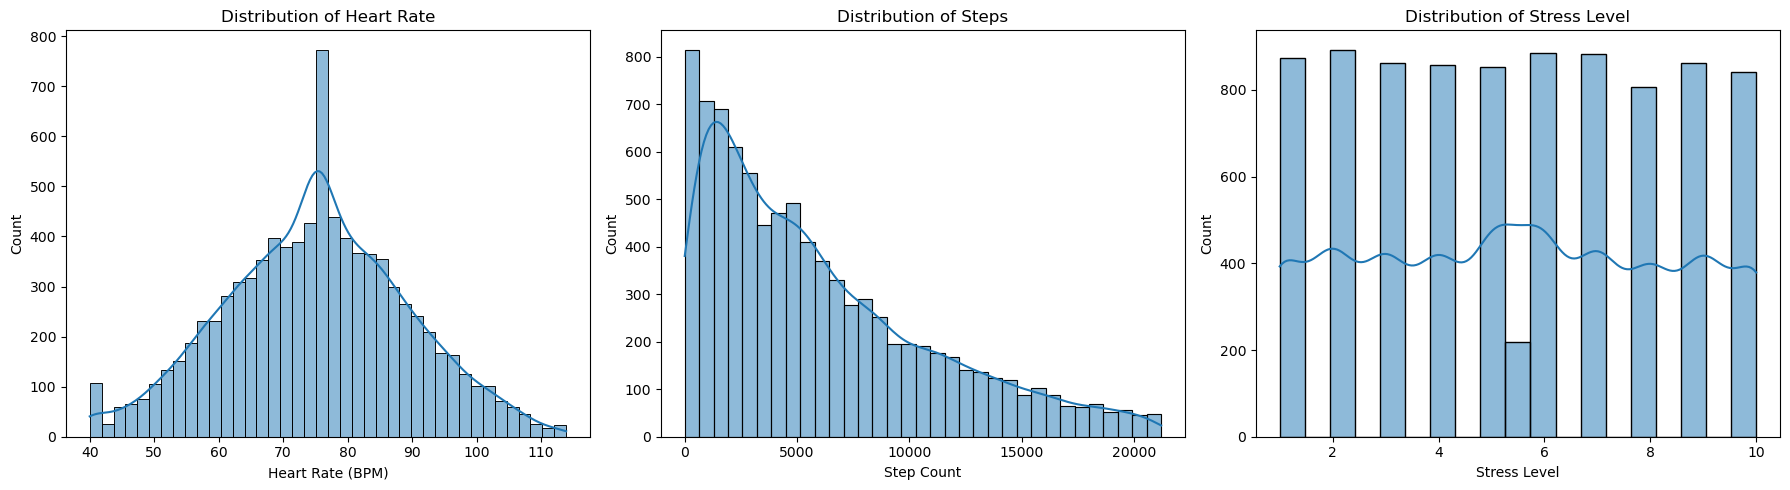

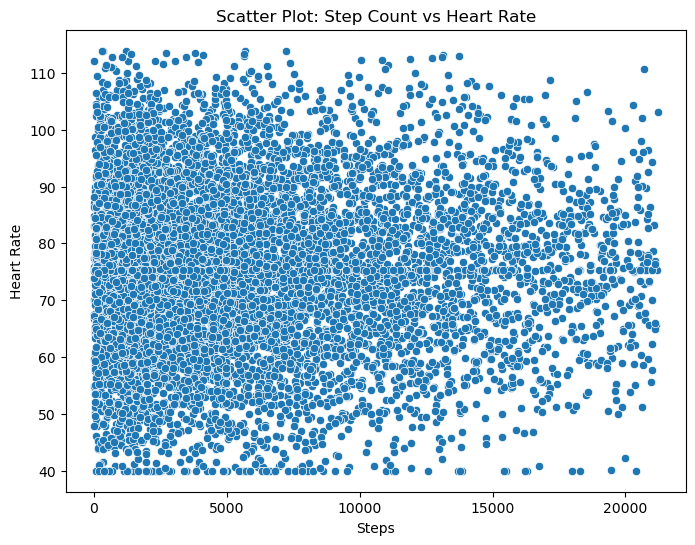

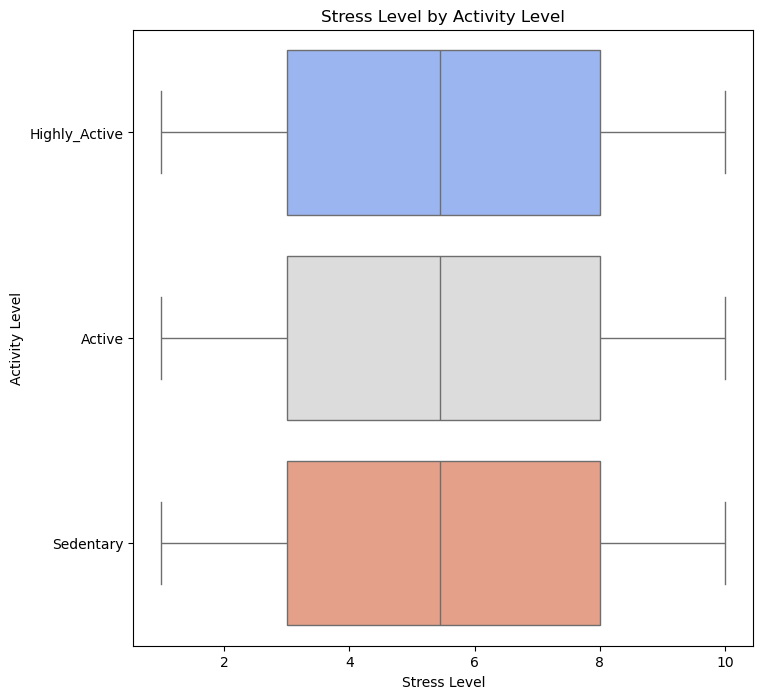

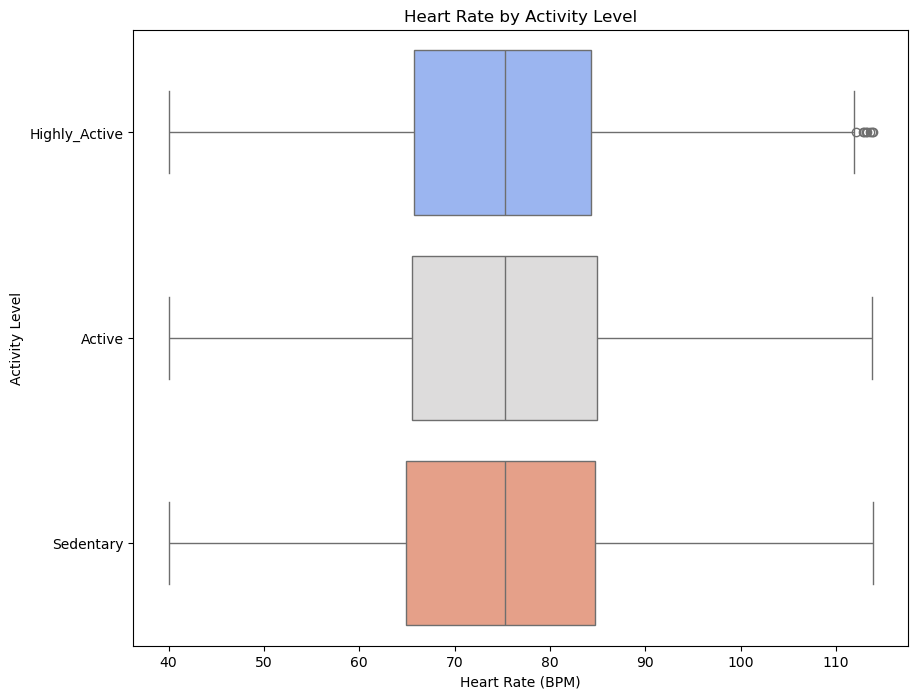

In [6]:
# Remove outliers
def outlier_remover(df, col):
    q1 = df[col].quantile(0.25) # calculate 1st quantile
    q3 = df[col].quantile(0.75) # calculate 3rd quantile
    IQR = q3 - q1 # calculate interquantile range
    lower_limit = q1 - 1.5 * IQR # calculate lower limit
    upper_limit = q3 + 1.5 * IQR # calculate upper limit
    df = df[(df[col] <= upper_limit) & (df[col] >= lower_limit)] # remove outliers
    return df

cols_with_outliers = ['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count', 'Sleep Duration (hours)', 'Stress Level']

for col in cols_with_outliers:
    df = outlier_remover(df, col)

# Plot histograms for key variables
fig, axs = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(df['Heart Rate (BPM)'], kde=True, ax=axs[0])
axs[0].set_title('Distribution of Heart Rate')
sns.histplot(df['Step Count'], kde=True, ax=axs[1])
axs[1].set_title('Distribution of Steps')
sns.histplot(df['Stress Level'], kde=True, ax=axs[2])
axs[2].set_title('Distribution of Stress Level')
plt.tight_layout()
plt.show()

# Create a scatter plot to explore th relationship between steps and heart rate
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Step Count', y='Heart Rate (BPM)', data=df)
plt.title('Scatter Plot: Step Count vs Heart Rate')
plt.xlabel('Steps')
plt.ylabel('Heart Rate')
plt.show()

plt.figure(figsize=(8,8))

sns.boxplot(
    data = df,
    x = 'Stress Level',
    y = 'Activity Level',
    palette = 'coolwarm',
    hue = 'Activity Level'
)

plt.legend([], [], frameon=False)
plt.title('Stress Level by Activity Level')
plt.xticks(size = 10)
plt.xlabel('Stress Level')
plt.ylabel('Activity Level')

plt.show()

plt.figure(figsize=(10,8))

sns.boxplot(
    data = df,
    x = 'Heart Rate (BPM)',
    y = 'Activity Level',
    palette = 'coolwarm',
    hue = 'Activity Level'
)

plt.legend([],[], frameon = False)
plt.title('Heart Rate by Activity Level')
plt.xticks(size = 10)
plt.xlabel('Heart Rate (BPM)')
plt.ylabel('Activity Level')

plt.show()


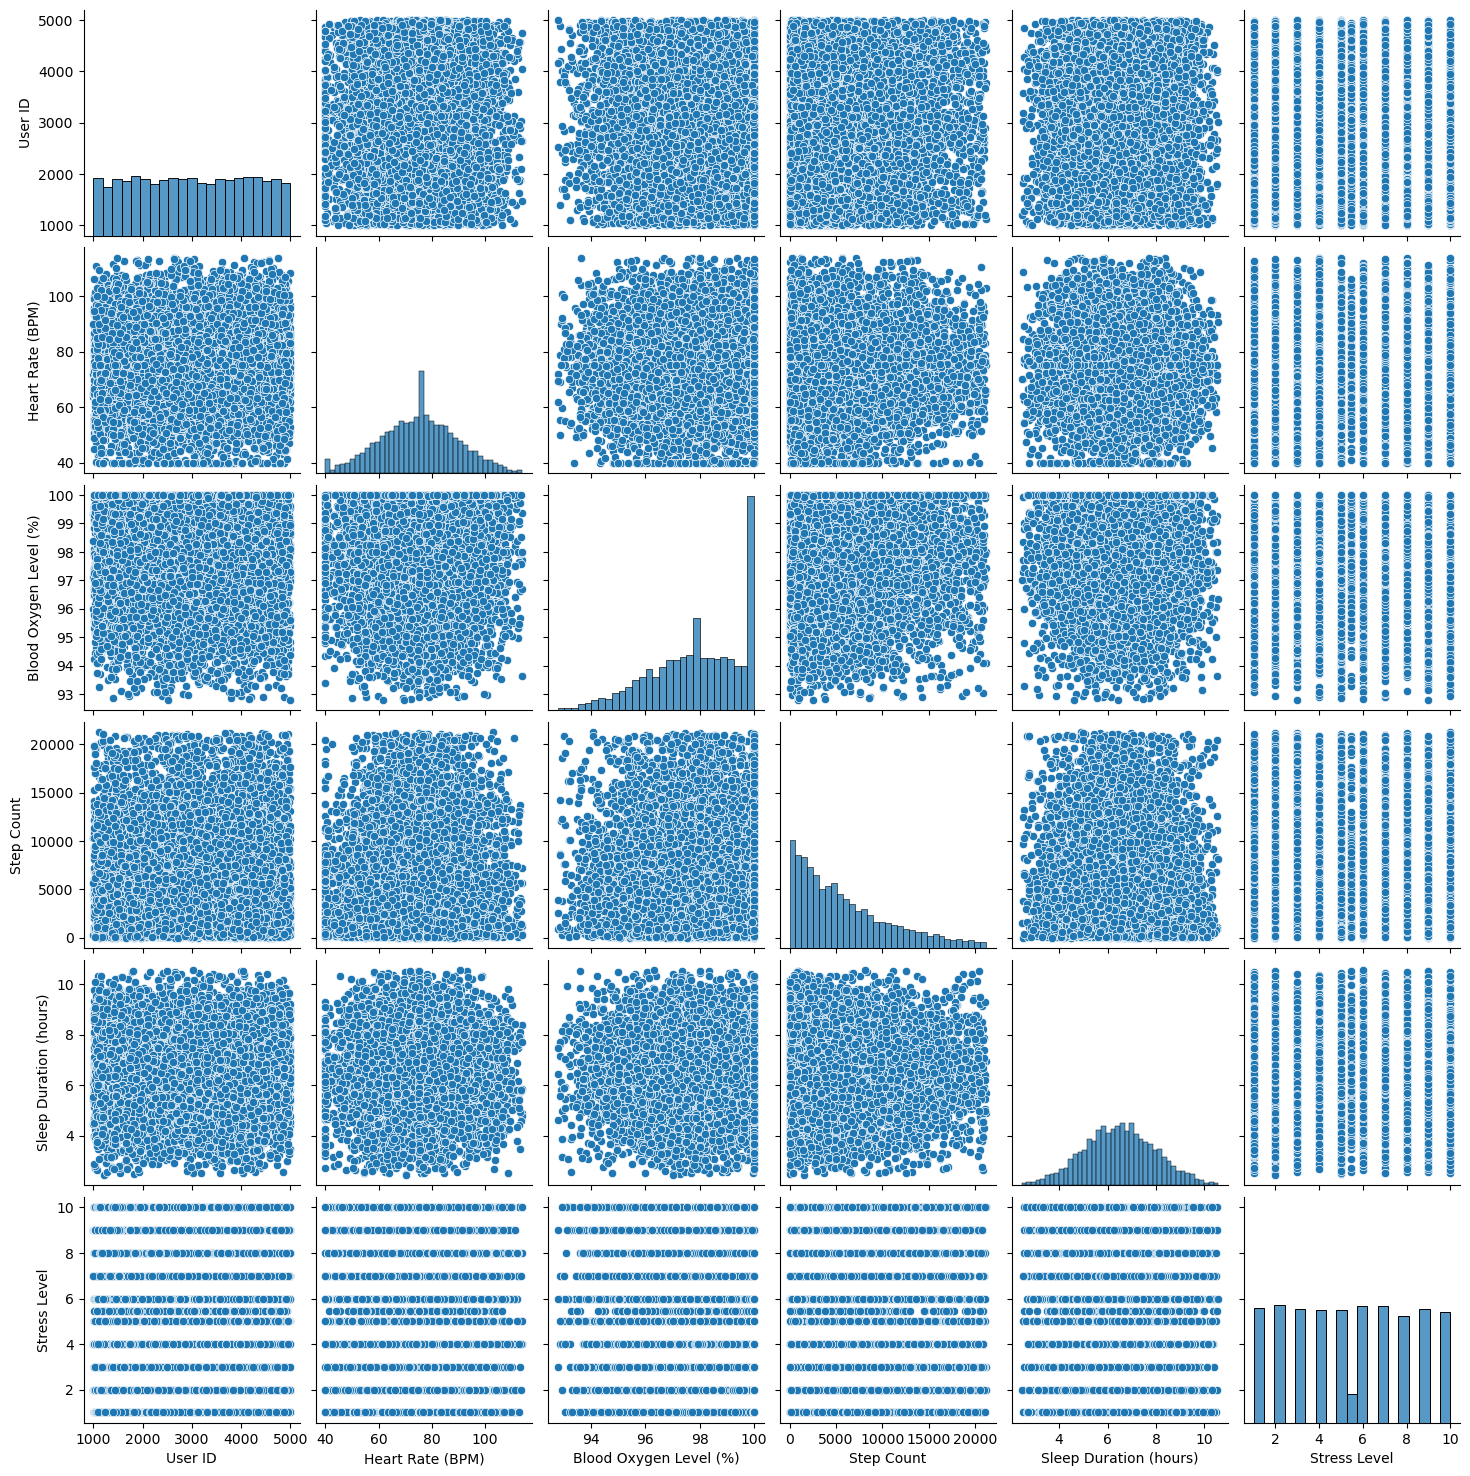

In [7]:
sns.pairplot(df)

## Feature Engineering: Estimated Calories Burned

Since the dataset lacks actual calorie values, we estimated calories burned using:

- **Sedentary:** Steps × 0.035
- **Active:** Steps × 0.040
- **Highly Active:** Steps × 0.045

This approach is supported by health studies and fitness guidelines. It reflects varying energy expenditure based on physical intensity.


In [8]:
# Estimate calories burned based on 'Step count' and 'Activity Level'

def estimate_calories(row):
    step_count = row['Step Count']
    level = row['Activity Level']
    if level == 'Sedentary':
        return step_count * 0.035 # minimal effort coefficient
    elif level == 'Active':
        return step_count * 0.04 # moderate effort coefficient
    elif level == 'Highly_Active':
        return step_count * 0.045 # high effort coefficient
    else:
        return step_count * 0.04 # default fallback coefficient

df['Calories Burned'] = df.apply(estimate_calories, axis=1)

print(df.head())

    User ID  Heart Rate (BPM)  Blood Oxygen Level (%)  Step Count  \
0    4174.0             58.94                   98.81     5450.39   
5    2294.0             40.00                   96.89    13797.34   
7    2095.0             96.29                   94.20    10205.99   
9    4772.0             47.27                   95.39     3208.78   
10   4092.0             81.73                   95.98     6051.25   

    Sleep Duration (hours) Activity Level  Stress Level  Calories Burned  
0                     7.17  Highly_Active           1.0        245.26755  
5                     7.37         Active           3.0        551.89360  
7                     8.38  Highly_Active          10.0        459.26955  
9                     7.87      Sedentary           2.0        112.30730  
10                    5.22      Sedentary           1.0        211.79375  


## Linear Regression: Predicting Calories Burned

To predict energy expenditure, we built a linear regression model using:

- **Independent Variables:** Step Count and Heart Rate (BPM)
- **Target Variable:** Estimated Calories Burned (calculated based on activity level)

The model achieved an **R² Score of 0.975**, indicating that it explains 97.5% of the variation in estimated calories burned.

### Model Coefficients:
- **Step Count coefficient:** 0.04 → strong positive predictor (~0.04 kcal per step)
- **Heart Rate (BPM) coefficient:** 0.016 → modest positive effect
- **Intercept:** -1.4 → baseline offset; not practically meaningful

### Interpretation:
- **Step Count** is the most significant contributor to calorie prediction.
- **Heart Rate** provides minor additional insight, but the flat trend in visualizations confirms its weaker role.
- The model overall is highly accurate and suitable for informing real-time activity feedback in smartwatch applications.


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Prepare data for regression 
x = df[['Step Count', 'Heart Rate (BPM)']]
y = df['Calories Burned']

# Train/Test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit linear regression model
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Evaluate model
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.3f}")
print("Coefficients: ", model.coef_)
print("Intercept:", model.intercept_)


R² Score: 0.975
Coefficients:  [0.04004482 0.01563215]
Intercept: -1.391581243252375


## Visualizing the Regression Results

The plots below illustrate how the model's predictions align with the data:

- **Step Count vs Estimated Calories Burned**  
  A strong linear relationship is observed. The regression line (red) closely follows the data points, confirming that step count is a reliable predictor of calorie expenditure.

- **Heart Rate vs Estimated Calories Burned**  
  The regression line appears nearly horizontal. This visual reinforces our earlier finding that heart rate contributes only marginally to calorie prediction compared to step count.

The shaded bands around the regression lines represent confidence intervals — they’re narrow for step count, indicating high prediction certainty, and much wider for heart rate, reflecting more variance and weaker correlation.


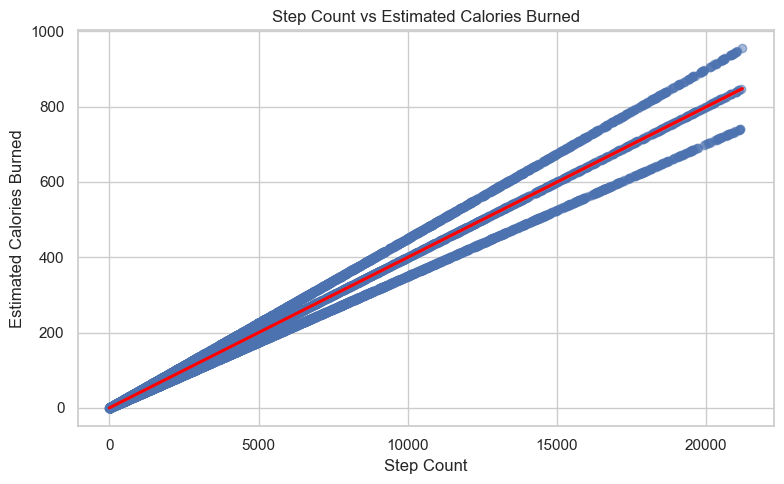

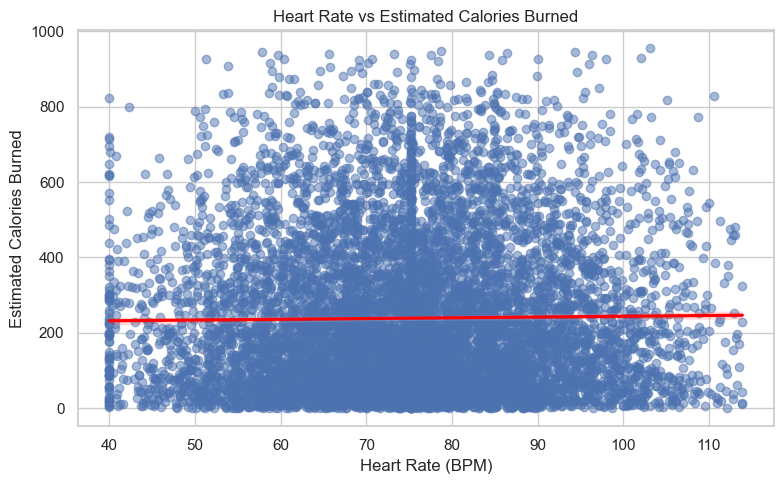

In [10]:
# Set seaborn style
sns.set(style='whitegrid')

# Plot 'Step Count' vs 'Calories Burned'
plt.figure(figsize=(8, 5))
sns.regplot(x='Step Count', y='Calories Burned', data=df, scatter_kws={'alpha': 0.5}, line_kws={"color": "red"})
plt.title('Step Count vs Estimated Calories Burned')
plt.xlabel('Step Count')
plt.ylabel('Estimated Calories Burned')
plt.tight_layout()
plt.show

# Plot 'Heart Rate' vs 'Calories Burned'
plt.figure(figsize=(8, 5))
sns.regplot(x='Heart Rate (BPM)', y='Calories Burned', data=df, scatter_kws={'alpha': 0.5}, line_kws={"color": "red"})
plt.title('Heart Rate vs Estimated Calories Burned')
plt.xlabel('Heart Rate (BPM)')
plt.ylabel('Estimated Calories Burned')
plt.tight_layout()
plt.show()

## Actionable Insights

Based on the data analysis and regression results, several key insights and actions can be recommended for improving user experience and health outcomes:

1. **Encourage Daily Step Goals**
   - Step Count showed the strongest correlation with Calories Burned.
   - Users should be encouraged to meet daily step targets (e.g., 8,000–10,000 steps) to ensure consistent energy expenditure and cardiovascular activity.

2. **Promote Accurate Activity Level Input**
   - Initial wrangling revealed typos and inconsistencies in the "Activity Level" field.
   - Action: Implement standardized input fields (e.g., dropdown menus) in smartwatch apps to avoid data quality issues and improve analytics.

3. **Use Personalized Calorie Estimates**
   - Estimated calories vary slightly based on activity classification.
   - Action: Integrate dynamic calorie calculators that adjust burn rates by activity level and potentially user-specific data (e.g., age, weight, gender).

4. **Leverage Heart Rate as a Supplementary Indicator**
   - Heart Rate (BPM) had a secondary but meaningful impact on calorie prediction.
   - Action: Use heart rate data to refine calorie estimates, particularly for detecting high-intensity bursts of activity.

5. **Build a Health Feedback Loop**
   - Combine activity tracking and calorie estimates to give users actionable feedback (e.g., “You’re 2,000 steps away from your burn target!”).
   - Action: Create personalized nudges based on real-time analytics to encourage user engagement and habit formation.

These insights can directly inform the design of health apps, smartwatch firmware, or personalized wellness programs that help users monitor and optimize their daily physical activity.


In [11]:
df.to_csv('cleaned_smartwatch_data.csv', index=False)